# Figure: How large should effect sizes be in neuroimaging to have sufficient power?

### Specification of alternative

In a brain map in an MNI template, with smoothness of 3 times the voxelsize, there are three similar active regions with voxelwise effect size D.  We want to know how large D should be in order to have 80% power to detect all three regions using voxelwise FWE thresholding using Random Field Theory.
Detect means: the maximum in the activated area exceeds the significance threshold.

### Strategy

1. Compute the voxelwise threshold for the specified smoothness and volume 
    * _FweThres = 5.12_
2. Compute the required power, so that the omnibus power is 80% 
    * _PowerPerRegion = 0.928_
3. How large should the maximum statistic in a (small) region be to exceed the voxelwise threshold with 0.928 power? 
    * _muMax = 4.47_
4. How does this maximum statistic translate to the voxel statistic?
    * _muVox = 2.7_
5. How does this voxel statistic translate to Cohen's D for a given sample size?

In [125]:
% matplotlib inline
from __future__ import division
import os
import nibabel as nib
import numpy as np
from neuropower import peakdistribution, neuropowermodels
import scipy.integrate as integrate
import pandas as pd
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb

## 1. What is the voxelwise threshold?

In [19]:
# From smoothness + mask to ReselCount

FWHM = 3
ReselSize = FWHM**3
MNI_mask = nib.load("MNI152_T1_2mm_brain_mask.nii.gz").get_data()
Volume = np.sum(MNI_mask)
ReselCount = Volume/ReselSize

print("ReselSize: "+str(ReselSize))
print("Volume: "+str(Volume))
print("ReselCount: "+str(ReselCount))
print("------------")

# From ReselCount to FWE treshold

FweThres_cmd = 'ptoz 0.05 -g %s' %ReselCount
FweThres = os.popen(FweThres_cmd).read()

print("FWE voxelwise GRF threshold: "+str(tmp))

ReselSize: 27
Volume: 228483
ReselCount: 8462.33333333
------------
FWE voxelwise GRF threshold: 5.123062



## 2. What should the power be in each region to have omnibus 80% power (find all 3) ?

In [60]:
power = 0.8
regions = 3
PowerPerRegion = 0.8**(1/3)
print("The power in each region should be: "+str(PowerPerRegion))

The power in each region should be: 0.928317766723


## 3. How large should the maximum statistic in a field be to exceed the threshold?

We quantify this by computing the expected local maximum in the field (which is a null field elevated by value D).
**Here we make the assumption that the activated field is so small that there is only one local maximum.**  We expect there to be only one local maximum if the activated region is smaller than 200 voxels (based on simulations), which seems reasonable. We use the distribution of local maxima of Cheng&Schwartzman to compute the power/effect size.

In [94]:
muRange = np.arange(1.8,5,0.01)
for muMax in muRange:
# what is the power to detect a maximum 
    power = 1-integrate.quad(lambda x:peakdistribution.peakdens3D(x,1),-20,float(FweThres)-muMax)[0]
    if power>PowerPerRegion:
        print("The power is larger than the required power per region if mu equals: "+str(muMax))
        break

The power is larger than the required power per region if mu equals: 4.47


## 4. From the required maximum statistic to the required voxelwise statistic

In [102]:
# expected peak height under null

xn = np.arange(-10,30,0.01)
alt = np.asarray([peakdistribution.peakdens3D(x,1) for x in xn])
nulMax = xn[alt==np.max(alt)][0]

print("The maximum in a field is "+str(nulMax)+" if the voxelwise effect is 0")

# peak height to voxelwise height

muVox = muMax - nulMax

print("The maximum in a field is "+str(muMax)+" if the voxelwise effect is "
+str(muMax)+"-"+str(nulMax)+"="+str(muVox))


The maximum in a field is 1.77 if the voxelwise effect is 0
The maximum in a field is 4.47 if the voxelwise effect is 4.47-1.77=2.7


## 5. From the required voxel statistic to Cohen's D for a given sample size

In [173]:
# Read in data
Data = pd.read_csv("tal_data.txt",sep=" ",header=None,names=['year','n'])
Data['source']='Tal'
David = pd.read_csv("david_data.txt",sep=" ",header=None,names=['year','n'])
David['source']='David'
Data=Data.append(David)

In [174]:
# add detectable effect
Data['delta']=muVox/np.sqrt(Data['n'])

In [190]:
# add jitter for figure
stdev = 0.01*(max(Data.year)-min(Data.year))
Data['year_jitter'] = Data.year+np.random.randn(len(Data))*stdev

In [198]:
# Compute medians per year (for smoother)
Medians = pd.DataFrame({'year':
                     np.arange(start=np.min(Data.year),stop=np.max(Data.year)),
                      'TalMdSS':'nan',
                     'DavidMdSS':'nan',
                      'TalMdD':'nan',
                     'DavidMdD':'nan',
                       })
for yearInd in range(len(Medians)):
    yearBoolTal = np.array([a and b for a,b in zip(Data.source=="Tal",Data.year==Medians.year[yearInd])])
    Medians.TalMdSS[yearInd] = np.median(Data.n[yearBoolTal])
    Medians.TalMdD[yearInd] = np.median(Data.delta[yearBoolTal])
    yearBoolDavid = np.array([a and b for a,b in zip(Data.source=="David",Data.year==Medians.year[yearInd])])
    Medians.DavidMdSS[yearInd] = np.median(Data.n[yearBoolDavid])
    Medians.DavidMdD[yearInd] = np.median(Data.delta[yearBoolDavid])

/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is tr

In [217]:
Medians[10:15]

,DavidMdD,DavidMdSS,TalMdD,TalMdSS,year
10,0.904205,9,0.839711,10.5,1998.0
11,0.954594,8,0.853815,10,1999.0
12,0.853815,10,1.0205,7,2000.0
13,0.853815,10,0.954594,8,2001.0
14,0.779423,12,0.853815,10,2002.0


## The figure

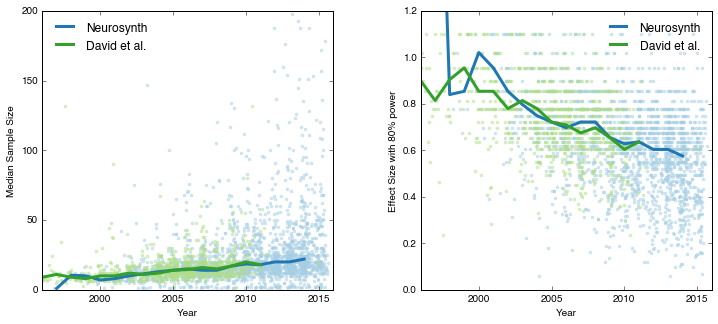

In [218]:
twocol = cb.qualitative.Paired_12.mpl_colors

fig,axs = plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(hspace=.5,wspace=.3)
axs=axs.ravel()
axs[0].plot(Data.year_jitter[Data.source=="Tal"],Data.n[Data.source=="Tal"],"r.",color=twocol[0],alpha=0.5,label="")
axs[0].plot(Data.year_jitter[Data.source=="David"],Data.n[Data.source=="David"],"r.",color=twocol[2],alpha=0.5,label="")
axs[0].plot(Medians.year,Medians.TalMdSS,color=twocol[1],lw=3,label="Neurosynth")
axs[0].plot(Medians.year,Medians.DavidMdSS,color=twocol[3],lw=3,label="David et al.")
axs[0].set_xlim([1996,2016])
axs[0].set_ylim([0,200])
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Median Sample Size")
axs[0].legend(loc="upper left",frameon=False)

axs[1].plot(Data.year_jitter[Data.source=="Tal"],Data.delta[Data.source=="Tal"],"r.",color=twocol[0],alpha=0.5,label="")
axs[1].plot(Data.year_jitter[Data.source=="David"],Data.delta[Data.source=="David"],"r.",color=twocol[2],alpha=0.5,label="")
axs[1].plot(Medians.year,Medians.TalMdD,color=twocol[1],lw=3,label="Neurosynth")
axs[1].plot(Medians.year,Medians.DavidMdD,color=twocol[3],lw=3,label="David et al.")
axs[1].set_xlim([1996,2016])
axs[1].set_ylim([0,1.2])
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Effect Size with 80% power")
axs[1].legend(loc="upper right",frameon=False)
plt.show()